# Topic modeling

### Load data

In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
CLEAN_SUBTITLES = '/home/angelo/Desktop/master_offline/progettone/subtitles/clean_subtitles/Disney/Animation'

subtitles = np.ndarray(shape=(0,3))

for r,d,files in os.walk(CLEAN_SUBTITLES):
    for f in files:
        with open(os.path.join(r,f), 'r', encoding='utf-8', errors='ignore') as r_fh:
            f_tokens = f.split('.')
            subtitles = np.append(subtitles, [[f_tokens[0], r[-4:], r_fh.read()]], axis=0)
            
documents = subtitles[:,2]

### Utils

In [3]:
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english') + ['shh', 'hoo', 'boo', 'uhoh', 'aah', 'heh', 'huh', 'ooh']

import spacy
nlp = spacy.load('en')

# split too long document (char_len > 1'000'000'000)
def lemmatization_single_doc(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text_split = []
    if len(text) > 1000000:
        split_pos = text.find('.', 900000)
        text_split.append(text[:split_pos+1])
        text_split.append(text[split_pos+1:])
    else:
        text_split.append(text)
        
    text_out = []
    for t in text_split:
        doc = nlp(t) 
        partial_tokens = [
            token.text if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags
        ]
        text_out = text_out + partial_tokens 
        
    return " ".join(text_out)  


def lemmatization(texts):
    texts_out = []
    for text in texts: 
        texts_out.append(lemmatization_single_doc(text, ['NOUN']))
    return texts_out


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f'Topic {topic_idx}: '
        message += ', '.join(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        )
        print(message,'\n')
    print()
    return

### Lemmatization and Tokenization

In [4]:
lem_documents = lemmatization(documents.tolist())

### Features extraction

In [5]:
tf_vectorizer = CountVectorizer(
    stop_words=en_stopwords,
    max_df=0.50,
    min_df=5,
    #ngram_range=(1,2),
    token_pattern='[a-zA-Z0-9]{3,}',
    lowercase=True
)

tf = tf_vectorizer.fit_transform(lem_documents)

### LDA

In [6]:
n_components = 10

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=10000,
    learning_method = 'batch',
    n_jobs=-1,
    verbose=0
)

lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10000,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [7]:
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic 0: king, ice, summer, storm, magic, sister, food, snow, winter, queen, past, squirrel, sun, fear, kings, roar, circle, lions, gates, danger 

Topic 1: bird, song, pig, forest, men, bear, rain, voice, ground, ship, tree, master, page, spring, pit, sound, prince, captain, apple, snow 

Topic 2: music, rat, dear, food, tea, chef, party, rabbit, merry, tail, lamp, stick, kitchen, expedition, strings, bees, photo, song, soup, restaurant 

Topic 3: fish, ocean, dad, future, school, science, parents, boat, mom, machine, mask, daddy, sea, game, island, memory, kids, sky, destiny, joy 

Topic 4: hero, lad, treasure, sword, farm, map, girls, town, nothin, king, devil, city, stone, gods, horse, star, bells, ship, money, captain 

Topic 5: tree, bear, village, food, river, gold, brother, bugs, bird, war, men, spirits, path, rock, wind, tail, warriors, cub, trees, land 

Topic 6: mom, kids, toy, toys, jungle, hat, box, cowboy, money, ship, buddy, brother, child, suit, birthday, bed, school, c

### Projecting documents into topics

In [8]:
topics = lda.transform(tf)

tdf = pd.DataFrame(topics)
tdf.insert(loc=0, column='decade', value=subtitles[:,1])
tdf.insert(loc=0, column='movie', value=subtitles[:,0])
print('shape:', tdf.shape)
tdf.head(10)

shape: (88, 12)


,movie,decade,0,1,2,3,4,5,6,7,8,9
0,Hercules,1990,0.000194,0.000194,0.000194,0.042195,0.855562,0.000194,0.100884,0.000194,0.000194,0.000194
1,Toy Story,1990,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.998345,0.000184,0.000184,0.000184
2,A Goofy Movie,1990,0.000268,0.000268,0.072829,0.352260,0.169974,0.000268,0.000268,0.042791,0.000268,0.360805
3,A Bug's Life,1990,0.000179,0.000179,0.062063,0.000179,0.000179,0.742893,0.071463,0.000179,0.000179,0.122506
4,The Nightmare Before Christmas,1990,0.000267,0.062530,0.167044,0.057704,0.076237,0.117196,0.333934,0.000267,0.184555,0.000267
5,The Lion King,1990,0.997783,0.000246,0.000246,0.000246,0.000246,0.000246,0.000246,0.000246,0.000246,0.000246
6,The Rescuers Down Under,1990,0.000329,0.000329,0.593687,0.000329,0.000329,0.000329,0.403681,0.000329,0.000329,0.000329
7,Aladdin,1990,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.998262,0.000193
8,Pocahontas,1990,0.000211,0.079482,0.000211,0.000211,0.000211,0.876931,0.000211,0.000211,0.038263,0.004056
9,Beauty and the Beast,1990,0.000225,0.150951,0.208812,0.000225,0.060437,0.022953,0.110853,0.015195,0.430123,0.000225


#### Dataframe to json graph (for visualization)

In [17]:
topic_nodes = set([str(c) for c in tdf.columns if c not in ['movie', 'decade']])
movie_nodes = set(tdf['movie'])

graph_list = []
for i in tdf.values:
    for t, j in enumerate(range(2, len(i))):
            graph_list.append((i[0], t, i[j]))
            
graph = dict()
graph["nodes"] = [{"id": tn, "group": 'topic'} for tn in topic_nodes]
graph["nodes"] = graph["nodes"] + [{"id": mn, "group": 'movie'} for mn in movie_nodes]
graph["links"] = [{"source":t[0], "target":str(t[1]), "value":float(t[2])} for t in graph_list]

with open('data.json', 'w') as outfile:
    json.dump(graph, outfile)

### Group by 'decade' then aggregate by 'mean'

In [10]:
mean_df = tdf.loc[:, tdf.columns != 'movie'].groupby(by=['decade']).agg('mean')
mean_df

,0,1,2,3,4,5,6,7,8,9
decade,,,,,,,,,,
1930,0.000356,0.709561,0.000356,0.000356,0.000356,0.000356,0.000356,0.000356,0.287592,0.000356
1940,0.000386,0.248762,0.105526,0.010441,0.000386,0.037862,0.036848,0.249652,0.176992,0.133146
1950,0.007555,0.134761,0.250698,0.008019,0.053573,0.010645,0.028039,0.069444,0.436983,0.000284
1960,0.056347,0.000247,0.129903,0.059521,0.151874,0.161788,0.186829,0.182367,0.060540,0.010584
1970,0.000286,0.162059,0.414797,0.000286,0.073739,0.021740,0.181975,0.074420,0.070413,0.000286
1980,0.000343,0.062832,0.245916,0.038604,0.105176,0.075789,0.000343,0.249188,0.221467,0.000343
1990,0.066744,0.031287,0.141331,0.030336,0.150061,0.158062,0.211271,0.012616,0.156938,0.041354
2000,0.041777,0.086952,0.117957,0.132132,0.088823,0.138785,0.185470,0.042280,0.055638,0.110186
2010,0.057019,0.027205,0.061058,0.146623,0.018849,0.093264,0.244663,0.057309,0.088292,0.205718


## ALL MOVIES OF A DECADE IN ONLY ONE DOCUMENT

### Load data

In [11]:
decade_subs = np.ndarray(shape=(0,2))

for r,d,files in os.walk(CLEAN_SUBTITLES):
    if (len(files) < 1):
        continue
        
    subs = str()
    for f in files:
        with open(os.path.join(r,f), 'r', encoding='utf-8', errors='ignore') as r_fh:
            subs = subs + ' ' + r_fh.read()
            
    decade_subs = np.append(decade_subs, [[r[-4:], subs]], axis=0)
            
decade_documents = decade_subs[:,1]

### Lemmatization and Tokenization

In [12]:
decade_lem_documents = lemmatization(decade_documents.tolist())

### Features extraction

In [13]:
decade_tf = tf_vectorizer.transform(decade_lem_documents)

### LDA - Projecting decade documents into topics

In [14]:
decade_topics = lda.transform(decade_tf)

### Decades - Topics dataframe

In [15]:
decade_tdf = pd.DataFrame(decade_topics)
decade_tdf.insert(loc=0, column='decade', value=decade_subs[:,0])
print('shape:', tdf.shape)
decade_tdf.set_index('decade',inplace=True)
decade_tdf.sort_index(inplace=True)
decade_tdf.head(10)

shape: (88, 12)


,0,1,2,3,4,5,6,7,8,9
decade,,,,,,,,,,
1930,0.000356,0.709561,0.000356,0.000356,0.000356,0.000356,0.000356,0.000356,0.287592,0.000356
1940,0.000086,0.122103,0.184765,0.000086,0.017630,0.045031,0.051250,0.168359,0.244845,0.165847
1950,0.000055,0.130096,0.309793,0.004052,0.052295,0.016372,0.020332,0.068915,0.398034,0.000055
1960,0.087587,0.000081,0.109355,0.062547,0.187209,0.168201,0.169908,0.122707,0.092324,0.000081
1970,0.000069,0.183675,0.340174,0.000069,0.087217,0.039022,0.194581,0.094738,0.060385,0.000069
1980,0.000064,0.080015,0.190281,0.046325,0.110196,0.068876,0.003867,0.212649,0.287664,0.000064
1990,0.038435,0.025365,0.116848,0.025416,0.156209,0.169229,0.259785,0.012570,0.150479,0.045663
2000,0.024969,0.047578,0.144624,0.145447,0.072440,0.094757,0.236771,0.035097,0.045890,0.152426
2010,0.016554,0.017313,0.040941,0.148719,0.000711,0.067165,0.256333,0.072194,0.091817,0.288252


## RESULT BY DECADE
#### Two aggregation methods: by "all in one decade document" and by mean

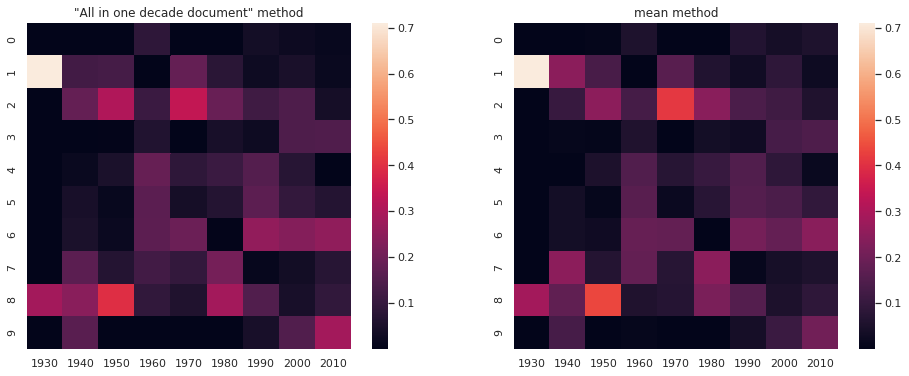

In [16]:
plt.figure(figsize=(16,6))

plt.subplot(121)
ax1 = sns.heatmap(decade_tdf.values.T, xticklabels=decade_tdf.index.values)
ax1.set_title('\"All in one decade document\" method')

plt.subplot(122)
ax2 = sns.heatmap(mean_df.values.T, xticklabels=mean_df.index.values)
ax2.set_title('mean method')

plt.show()